# Čiščenje podatkov

In [91]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import seaborn as sns
import os.path
from sklearn.neighbors import LocalOutlierFactor

In [92]:
panj = pd.read_pickle("./panj_cleaned.pkl")  
dnevnik = pd.read_pickle('./dnevnik_cleaned.pkl')
vreme = pd.read_pickle('./vreme_cleaned.pkl')

# Skoncentriramo se na en mesec

In [93]:
panj['year'] = panj['date'].dt.year
panj['month'] = panj['date'].dt.month

In [94]:
panj = panj.loc[panj['month'] == 6]
panj = panj.loc[panj['year'] == 2019]

Odstranitev osamelcev (outlier removal)

([<matplotlib.axis.XTick at 0x2316c1b8c90>,
 [Text(18077.958333333332, 0, '2019-06-30'),
  Text(18075.75, 0, '2019-06-28'),
  Text(18070.625, 0, '2019-06-23'),
  Text(18068.458333333332, 0, '2019-06-21'),
  Text(18066.291666666668, 0, '2019-06-19'),
  Text(18064.0, 0, '2019-06-17'),
  Text(18061.833333333332, 0, '2019-06-14'),
  Text(18059.458333333332, 0, '2019-06-12'),
  Text(18057.291666666668, 0, '2019-06-10'),
  Text(18055.125, 0, '2019-06-08'),
  Text(18052.958333333332, 0, '2019-06-05'),
  Text(18050.75, 0, '2019-06-03'),
  Text(18048.583333333332, 0, '2019-06-01')])

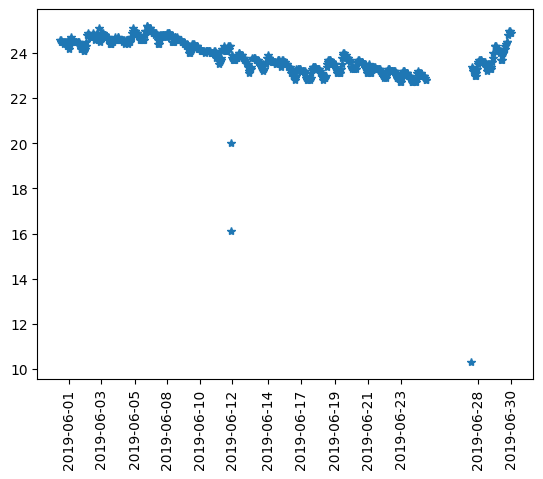

In [95]:
plt.plot(panj['date'], panj['resVal'], '*')
plt.xticks(panj['date'][::50],  rotation='vertical')

In [96]:
def replace_outliers_with_local_mean(df, col_name, window_size=5, threshold=3):
    # Create a copy of the DataFrame to avoid modifying the original data
    df_modified = df.copy()

    # Calculate the z-score for the entire column
    z_scores = (df_modified[col_name] - df_modified[col_name].mean()) / df_modified[col_name].std()

    # Identify potential outliers based on the z-score and the given threshold
    potential_outliers = df_modified[abs(z_scores) > threshold]

    # Iterate over potential outliers and replace with local mean
    for idx in potential_outliers.index:
        left_idx = max(idx - window_size // 2, 0)
        right_idx = min(idx + window_size // 2, len(df_modified) - 1)
        local_mean = df_modified.loc[left_idx:right_idx, col_name].mean()
        df_modified.at[idx, col_name] = local_mean

    return df_modified

In [97]:
panj_test = replace_outliers_with_local_mean(panj, "resVal", window_size=2, threshold=2)

In [98]:
panj_test.head()

,resId,siteNo,hiveNo,frameNo,hour,paramText,anMethText,resVal,resUnit,resUnit_desc,resValUncert,resValUncertSD,resQualValue,date,year,month
161245,CW208467,3,1,NaN,23,Colony weight,Automatic recording,24.9,G167A,Kilogram,NaN,NaN,NaN,2019-06-30 23:00:00,2019,6
161246,CW208466,3,1,NaN,22,Colony weight,Automatic recording,24.9,G167A,Kilogram,NaN,NaN,NaN,2019-06-30 22:00:00,2019,6
161247,CW208465,3,1,NaN,21,Colony weight,Automatic recording,25.0,G167A,Kilogram,NaN,NaN,NaN,2019-06-30 21:00:00,2019,6
161249,CW208464,3,1,NaN,20,Colony weight,Automatic recording,25.0,G167A,Kilogram,NaN,NaN,NaN,2019-06-30 20:00:00,2019,6
161250,CW208463,3,1,NaN,18,Colony weight,Automatic recording,24.8,G167A,Kilogram,NaN,NaN,NaN,2019-06-30 18:00:00,2019,6


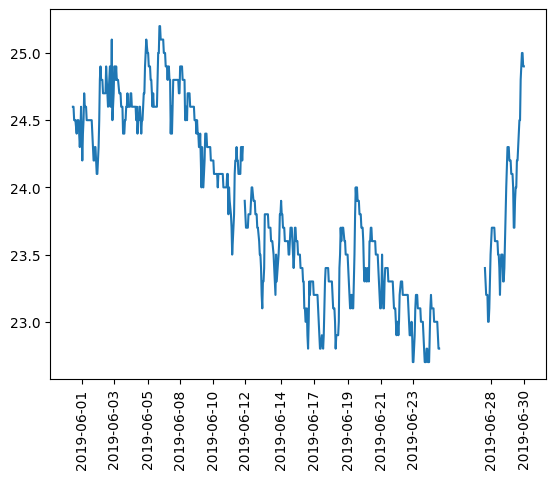

In [99]:
plt.plot(panj_test['date'], panj_test['resVal'], '-')
plt.xticks(panj_test['date'][::50],  rotation='vertical')
plt.show()

Dodamo vmesno crto kjer manjkajo vrednosti

In [100]:
def create_line_from_nearest_values(df, date_col, value_col):
    # Make sure the DataFrame is sorted by the datetime column
    df = df.sort_values(by=[date_col])

    # Interpolate missing values using linear interpolation
    df[value_col] = df[value_col].interpolate(method='linear')

    return df

In [101]:
panj = create_line_from_nearest_values(panj_test, "date", "resVal")

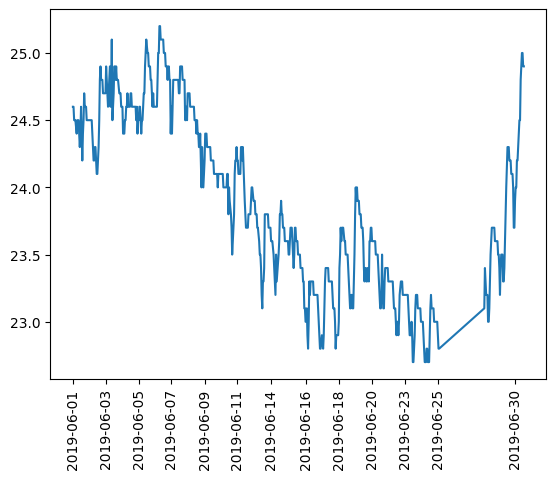

In [102]:
plt.plot(panj['date'], panj['resVal'], '-')
plt.xticks(panj['date'][::50],  rotation='vertical')
plt.show()

Shranimo dataset

In [103]:
panj.to_pickle("./panj_outlier.pkl")